In [ ]:
# Eval Function

import csv
import unicodedata
from collections import defaultdict, Counter
import numpy as np
from scipy.stats import spearmanr, pearsonr

def evaluate_model(results_file, experimental_file):
    print()
    print("Reading results file:", results_file)

    # -------------------------
    # Data containers
    # -------------------------
    ratings_per_sentence = defaultdict(list)
    gold_rating_per_sentence = {}
    label_dict = {}
    status_dict = {}
    syntactic_dict = {}
    trace_dict = {}
    critical_sentence_set = set()
    baseline_sentence_set = set()
    rating_diff_data = []

    # Likert mapping
    grade_map = {'a': 5, 'b': 3, 'c': 1, 'd': -5, 'e': 0}

    model_letters_all = []
    model_letters_critical = []
    model_letters_baseline = []

    # -------------------------
    # Normalization (light)
    # -------------------------
    def normalize(text):
        if not text:
            return ""
        text = unicodedata.normalize('NFKD', text)
        text = text.encode('ascii', 'ignore').decode('utf-8')
        text = text.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')
        return text.strip().lower()

    # -------------------------
    # Step 1: Read gold data
    # -------------------------
    with open(experimental_file, mode='r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            sentence_id = row.get('ID') or row.get('Index') or row.get('sentence_id', '').strip()
            sentence = normalize(row.get('French Sentences', ''))
            try:
                gold_rating = float(row.get('gold_ratings', 0))
            except:
                gold_rating = 0

            label_dict[sentence] = sentence_id
            gold_rating_per_sentence[sentence] = gold_rating

            status = row.get('status', '').strip().lower()
            if status == 'critical':
                critical_sentence_set.add(sentence)
            elif status == 'baseline':
                baseline_sentence_set.add(sentence)

    # -------------------------
    # Step 2: Read model outputs
    # -------------------------
    with open(results_file, mode='r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            # Determine which column has the sentence
            sentence_col = 'French Sentences' if 'French Sentences' in row else list(row.keys())[0]
            sentence = normalize(row.get(sentence_col, ''))

            # Determine which column has model answer
            model_answer_col = 'models_answer' if 'models_answer' in row else list(row.keys())[-1]
            ratings_per_sentence[sentence].append(row.get(model_answer_col, ''))

            # Optional columns
            status_dict[sentence] = row.get('status', 'unknown')
            syntactic_dict[sentence] = row.get('syntactic position', '')
            trace_dict[sentence] = row.get('trace position', '')

    # -------------------------
    # Helper: extract Likert grade
    # -------------------------
    def extract_grade(text):
        if not text:
            return None
        cleaned = normalize(text)
        for ch in cleaned:
            if ch in grade_map:
                return ch
        return None

    # -------------------------
    # Step 3: Sentence-level scoring
    # -------------------------
    for sentence, answers in ratings_per_sentence.items():
        if sentence not in gold_rating_per_sentence:
            continue

        model_scores = []

        for ans in answers:
            grade = extract_grade(ans)
            if grade is None:
                continue

            model_letters_all.append(grade)
            model_scores.append(grade_map[grade])

            if sentence in critical_sentence_set:
                model_letters_critical.append(grade)
            elif sentence in baseline_sentence_set:
                model_letters_baseline.append(grade)

        if not model_scores:
            continue

        mean_model = np.mean(model_scores)
        gold = gold_rating_per_sentence[sentence]

        rating_diff_data.append({
            'sentence': sentence,
            'label': label_dict.get(sentence, 'unknown'),
            'model_ratings': model_scores,
            'mean_model': mean_model,
            'mean_gold': gold,
            'rating_diff_abs': abs(mean_model - gold),
            'rating_diff_signed': mean_model - gold,
            'status': status_dict.get(sentence, 'unknown')
        })

    # -------------------------
    # Step 4: Sanity check
    # -------------------------
    missing = set(gold_rating_per_sentence) - set(ratings_per_sentence)
    print(f"Missing model outputs: {len(missing)}")

    # -------------------------
    # Step 5: Global statistics
    # -------------------------

    model_means = [x['mean_model'] for x in rating_diff_data]
    gold_means = [x['mean_gold'] for x in rating_diff_data]
    signed_diffs = [x['rating_diff_signed'] for x in rating_diff_data]

    mean_abs_diff = np.mean([x['rating_diff_abs'] for x in rating_diff_data])
    msd = np.mean(signed_diffs)
    # model SD within-item (average over items)
    model_item_sds = []
    for x in rating_diff_data:
        if len(x["model_ratings"]) >= 2:
            model_item_sds.append(np.std(x["model_ratings"], ddof=1))

    sd_model_within = float(np.mean(model_item_sds)) if model_item_sds else float("nan")

    print("\n--- Global Alignment ---")
    print("Mean |Δ|:", round(mean_abs_diff, 2))
    print("Mean signed Δ (MSD / bias):", round(msd, 2))
    print("Model SD (within-item):", round(sd_model_within, 2))


    # correlations are left out because not in line with original paper evaluation
    '''# -------------------------
    # Step 6: Correlations
    # -------------------------
    spearman = spearmanr(model_means, gold_means)
    pearson = pearsonr(model_means, gold_means)

    print("\n--- Correlation ---")
    print(f"Spearman ρ = {spearman.statistic:.3f} (p={spearman.pvalue:.4f})")
    print(f"Pearson r = {pearson[0]:.3f} (p={pearson[1]:.4f})")'''

    # -------------------------
    # Step 7: Binning
    # -------------------------
    def bin_differences(data):
        bins = {"0–1": 0, "1–2": 0, "2–3": 0, "3–4": 0, ">4": 0}
        for item in data:
            d = item['rating_diff_abs']
            if d < 1:
                bins["0–1"] += 1
            elif d < 2:
                bins["1–2"] += 1
            elif d < 3:
                bins["2–3"] += 1
            elif d < 4:
                bins["3–4"] += 1
            else:
                bins[">4"] += 1
        return bins

    total_all = len(rating_diff_data)
    critical_data = [x for x in rating_diff_data if x['sentence'] in critical_sentence_set]
    baseline_data = [x for x in rating_diff_data if x['sentence'] in baseline_sentence_set]

    bins_all = bin_differences(rating_diff_data)
    bins_critical = bin_differences(critical_data)
    bins_baseline = bin_differences(baseline_data)

    print("\n--- Binned Rating Differences (ALL items) ---")
    for k, v in bins_all.items():
        print(f"{k}: {v} ({(v/total_all*100):.2f}%)")

    print("\n--- Binned Rating Differences (Critical, % of ALL items) ---")
    for k, v in bins_critical.items():
        print(f"{k}: {v} ({(v/len(critical_data)*100):.2f}%)")

    print("\n--- Binned Rating Differences (Baseline, % of ALL items) ---")
    for k, v in bins_baseline.items():
        print(f"{k}: {v} ({(v/len(baseline_data)*100):.2f}%)")

    # -------------------------
    # Step 8: Likert usage
    # -------------------------
    def print_distribution(lst, name):
        c = Counter(lst)
        total = sum(c.values())
        print(f"\n{name}")
        for g in ['a', 'b', 'c', 'd', 'e']:
            print(f"{g.upper()}: {c[g]} ({(c[g]/total*100 if total else 0):.2f}%)")

    print_distribution(model_letters_all, "All items")
    print_distribution(model_letters_critical, "Critical items")
    print_distribution(model_letters_baseline, "Baseline items")

    return rating_diff_data, model_letters_all, msd


In [ ]:
import csv
from collections import defaultdict, Counter
import numpy as np
import unicodedata
from scipy.stats import spearmanr, pearsonr

# Each model = independent evaluation

experimental_file = "experimental_items_X1_to_X68.csv"

'''model_files = {
    "GPT-4o-mini": "all_accept_zeroshot_gpt-4o-mini.csv",
    "O4-mini": "all_accept_zeroshot_o4-mini.csv",
    "LLaMA-3.3-70B": "60_BarbosaDeCat_llama_zeroshot_t0.3.csv",
    "Mistral-24B": "60_BarbosaDeCat_mistral_zeroshot_t0.3.csv"
}'''

model_files = {
    "GPT-4o-mini": "all_accept_cotshot_gpt-4o-mini.csv",
    "O4-mini": "all_accept_cotshot_o4-mini.csv",
    "LLaMA-3.3-70B": "60_BarbosaDeCat_llama_CoT_t0.3.csv",
    "Mistral-24B": "60_BarbosaDeCat_mistral_CoT_t0.3.csv"
}

results_by_model_data = {}
metrics_by_model = {}
likert_by_model = {}

for model_name, result_file in model_files.items():
    print("##########", model_name, "########")

    rating_diff_data, model_letters, _ = evaluate_model(
        results_file=result_file,
        experimental_file=experimental_file
    )

    results_by_model_data[model_name] = rating_diff_data
    likert_by_model[model_name] = model_letters

    # MAD/MSD computed across item means (this is correct)
    model_means = np.array([x['mean_model'] for x in rating_diff_data])
    gold_means  = np.array([x['mean_gold']  for x in rating_diff_data])

    mad = np.mean(np.abs(model_means - gold_means))
    msd = np.mean(model_means - gold_means)

    # SD within-item (mean across items) -- this is the corrected SD
    item_sds = [
        np.std(x["model_ratings"], ddof=1)
        for x in rating_diff_data
        if "model_ratings" in x and len(x["model_ratings"]) >= 2
    ]
    sd_model_within = float(np.mean(item_sds)) if item_sds else float("nan")

    metrics_by_model[model_name] = {
        'MAD': float(mad),
        'MSD': float(msd),
        'SD_model_within': sd_model_within,   # renamed for clarity
    }

for m in metrics_by_model:
    print(m, metrics_by_model[m])

print("\nSanity check:")
for model, data in results_by_model_data.items():
    mean_abs_diff = np.mean([x['rating_diff_abs'] for x in data])
    print(f"{model}: items = {len(data)}, mean |Δ| = {mean_abs_diff:.2f}")

########## GPT-4o-mini ########

Reading results file: all_accept_cotshot_gpt-4o-mini.csv
Missing model outputs: 2

--- Global Alignment ---
Mean |Δ|: 1.95
Mean signed Δ (MSD / bias): -1.33
Model SD (within-item): 2.04

--- Binned Rating Differences (ALL items) ---
0–1: 29 (45.31%)
1–2: 14 (21.88%)
2–3: 5 (7.81%)
3–4: 2 (3.12%)
>4: 14 (21.88%)

--- Binned Rating Differences (Critical, % of ALL items) ---
0–1: 18 (40.91%)
1–2: 12 (27.27%)
2–3: 4 (9.09%)
3–4: 0 (0.00%)
>4: 10 (22.73%)

--- Binned Rating Differences (Baseline, % of ALL items) ---
0–1: 11 (55.00%)
1–2: 2 (10.00%)
2–3: 1 (5.00%)
3–4: 2 (10.00%)
>4: 4 (20.00%)

All items
A: 1146 (29.84%)
B: 80 (2.08%)
C: 1427 (37.16%)
D: 1187 (30.91%)
E: 0 (0.00%)

Critical items
A: 577 (21.86%)
B: 70 (2.65%)
C: 1192 (45.15%)
D: 801 (30.34%)
E: 0 (0.00%)

Baseline items
A: 569 (47.42%)
B: 10 (0.83%)
C: 235 (19.58%)
D: 386 (32.17%)
E: 0 (0.00%)
########## O4-mini ########

Reading results file: all_accept_cotshot_o4-mini.csv
Missing model out

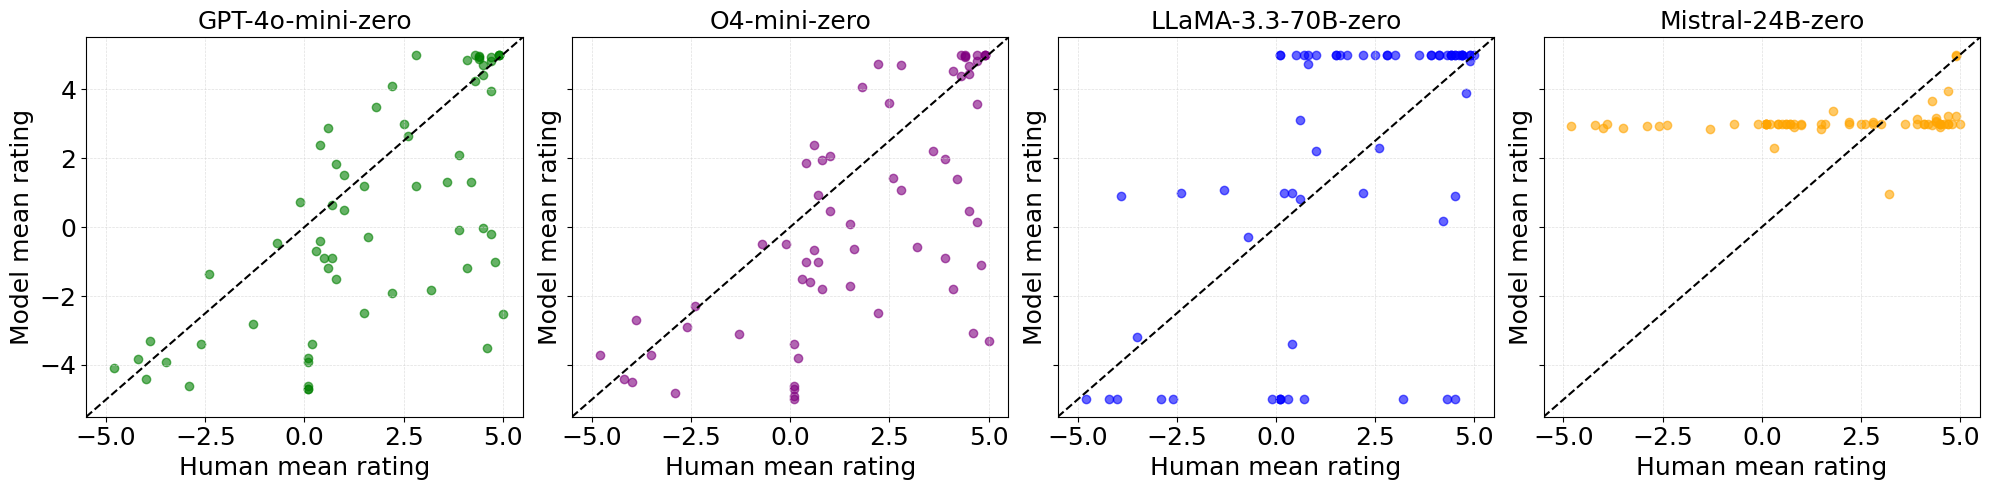

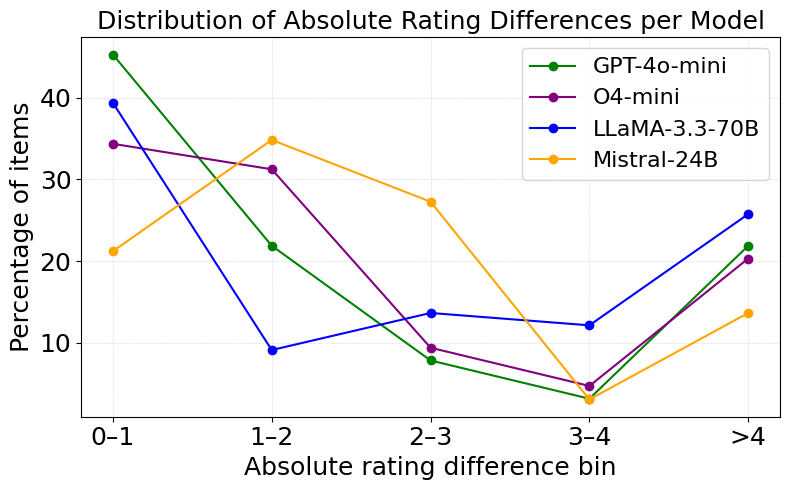

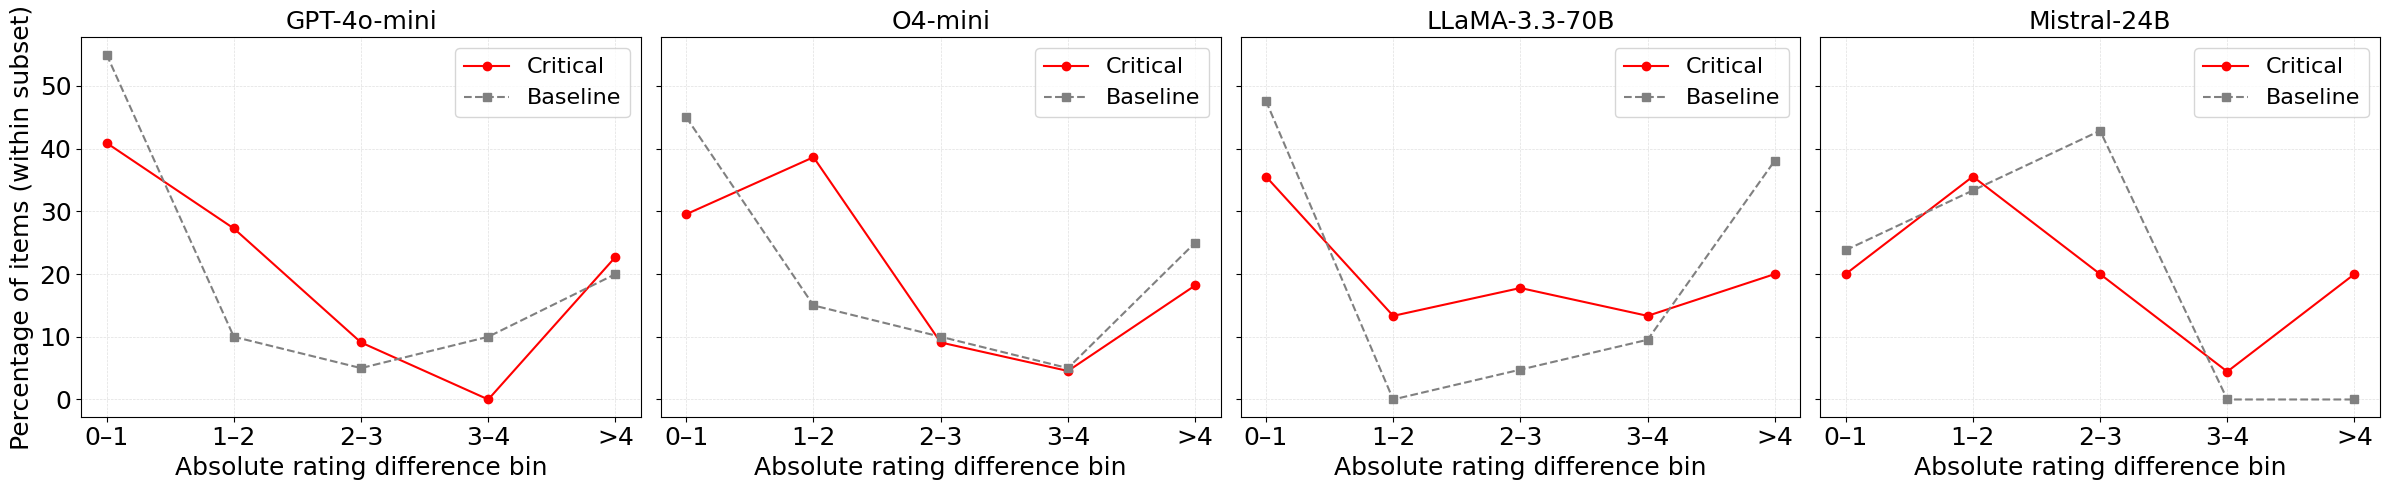

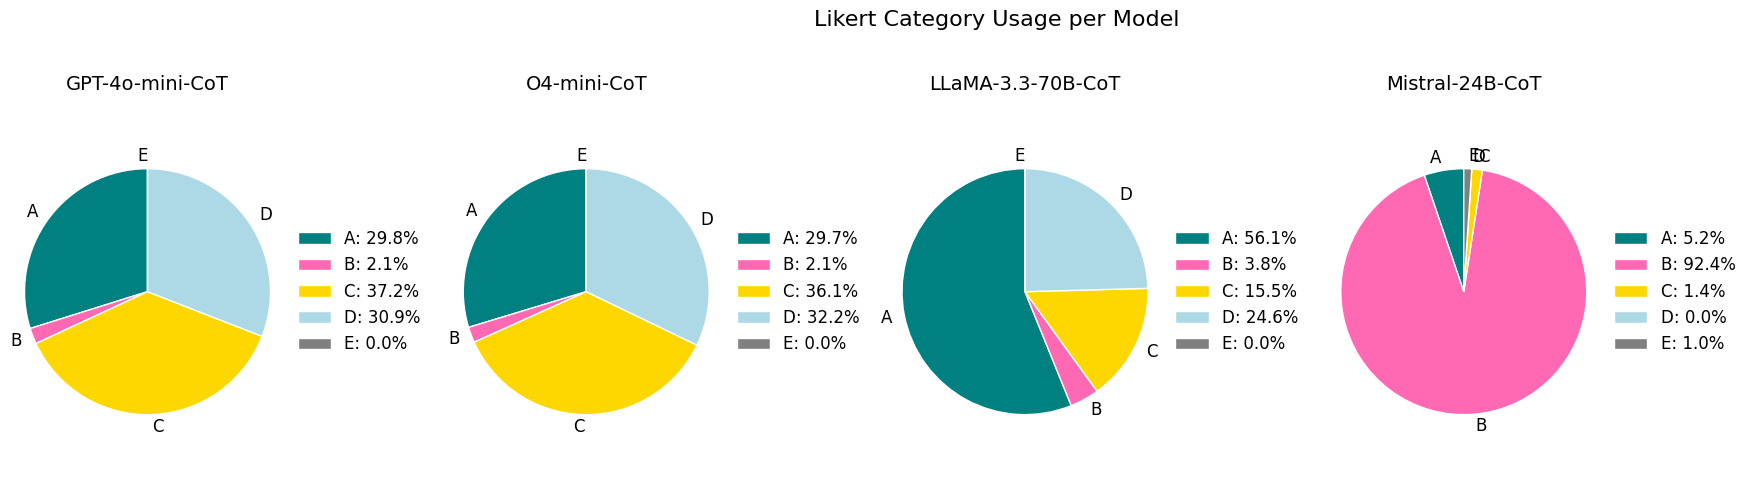

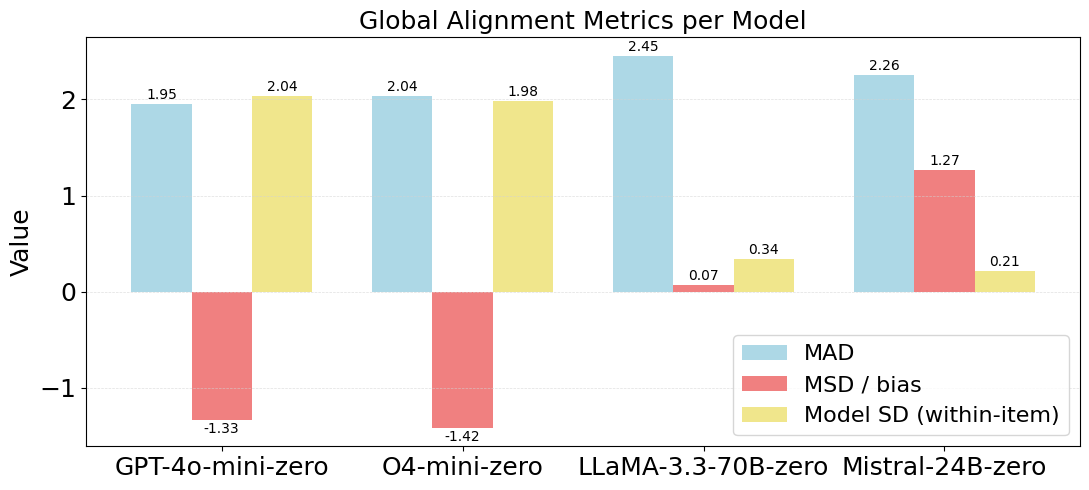

In [ ]:
# Figures

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# 1) Model-human alignment (scatter of per-item means)
def plot_alignment(results_by_model, setting_label="CoT", fontsize=18):
    color_map = {
        "GPT-4o-mini": "green",
        "O4-mini": "purple",
        "LLaMA-3.3-70B": "blue",
        "Mistral-24B": "orange"
    }

    # Determine axis limits from data (safe for different scales)
    all_h = []
    all_m = []
    for _, data in results_by_model.items():
        all_h.extend([x['mean_gold'] for x in data])
        all_m.extend([x['mean_model'] for x in data])

    if all_h and all_m:
        lo = min(min(all_h), min(all_m))
        hi = max(max(all_h), max(all_m))
        pad = 0.05 * (hi - lo) if hi > lo else 1.0
        lims = (lo - pad, hi + pad)
    else:
        lims = (-6, 6)

    n = len(results_by_model)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5), sharex=True, sharey=True)
    if n == 1:
        axes = [axes]

    for ax, (model, data) in zip(axes, results_by_model.items()):
        human = [x['mean_gold'] for x in data]
        model_scores = [x['mean_model'] for x in data]

        ax.scatter(human, model_scores, alpha=0.6, color=color_map.get(model, "gray"))
        ax.plot([lims[0], lims[1]], [lims[0], lims[1]], linestyle='--', color='black')

        ax.set_xlim(lims)
        ax.set_ylim(lims)

        ax.set_title(f"{model}-{setting_label}", fontsize=fontsize)
        ax.set_xlabel("Human mean rating", fontsize=fontsize)
        ax.set_ylabel("Model mean rating", fontsize=fontsize)
        ax.tick_params(axis='both', labelsize=fontsize)

        ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()


# 2) Distribution of absolute rating differences (bins over items, based on abs(mean_model - mean_gold))
def bin_differences(data):
    bins = {"0–1": 0, "1–2": 0, "2–3": 0, "3–4": 0, ">4": 0}
    for x in data:
        d = x['rating_diff_abs']
        if d < 1:
            bins["0–1"] += 1
        elif d < 2:
            bins["1–2"] += 1
        elif d < 3:
            bins["2–3"] += 1
        elif d < 4:
            bins["3–4"] += 1
        else:
            bins[">4"] += 1
    return bins


def plot_binned_differences(results_by_model, fontsize=18):
    labels = ["0–1", "1–2", "2–3", "3–4", ">4"]
    x = np.arange(len(labels))

    color_map = {
        "GPT-4o-mini": "green",
        "O4-mini": "purple",
        "LLaMA-3.3-70B": "blue",
        "Mistral-24B": "orange"
    }

    fig, ax = plt.subplots(figsize=(8, 5))

    for model, data in results_by_model.items():
        bins = bin_differences(data)
        total = len(data)
        percentages = [(bins[l] / total) * 100 if total else 0 for l in labels]

        ax.plot(x, percentages, marker='o', label=model, color=color_map.get(model, "gray"))

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=fontsize)
    ax.set_ylabel("Percentage of items", fontsize=fontsize)
    ax.set_xlabel("Absolute rating difference bin", fontsize=fontsize)
    ax.set_title("Distribution of Absolute Rating Differences per Model", fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(fontsize=fontsize-2)

    plt.tight_layout()
    plt.show()


# 3) Critical vs baseline divergence (bins over abs diffs, denominators match each subset)
def plot_critical_baseline(results_by_model, fontsize=18):
    labels = ["0–1", "1–2", "2–3", "3–4", ">4"]
    x = np.arange(len(labels))

    fig, axes = plt.subplots(1, len(results_by_model), figsize=(6*len(results_by_model), 5), sharey=True)
    if len(results_by_model) == 1:
        axes = [axes]

    for ax, (model, data) in zip(axes, results_by_model.items()):
        critical = [d for d in data if d.get('status') == 'critical']
        baseline = [d for d in data if d.get('status') == 'baseline']

        bins_c = bin_differences(critical)
        bins_b = bin_differences(baseline)

        total_c = len(critical)
        total_b = len(baseline)

        perc_c = [(bins_c[l] / total_c) * 100 if total_c else 0 for l in labels]
        perc_b = [(bins_b[l] / total_b) * 100 if total_b else 0 for l in labels]

        ax.plot(x, perc_c, marker='o', label='Critical', color='red')
        ax.plot(x, perc_b, marker='s', linestyle='--', label='Baseline', color='gray')

        ax.set_title(model, fontsize=fontsize)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=fontsize)
        ax.set_xlabel("Absolute rating difference bin", fontsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)
        ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
        ax.legend(fontsize=fontsize-2)

    axes[0].set_ylabel("Percentage of items (within subset)", fontsize=fontsize)
    plt.tight_layout()
    plt.show()


# 4) Likert label usage
def plot_likert_usage(letters_by_model, setting_label="CoT", fontsize=18):
    models = list(metrics_by_model.keys())
    labels = ['A', 'B', 'C', 'D', 'E']
    colors = ['#008080', '#ff69b4', '#ffd700', '#add8e6', '#808080']

    n = len(letters_by_model)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    if n == 1:
        axes = [axes]

    for ax, (model, letters) in zip(axes, letters_by_model.items()):
        counts = Counter(letters)
        sizes = [counts[l.lower()] for l in labels]
        total = sum(sizes)

        wedges, _ = ax.pie(
            sizes,
            labels=labels,
            startangle=90,
            colors=colors,
            textprops={'fontsize': fontsize-6},
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
        )

        legend_labels = [
            f"{label}: {sizes[i]/total*100:.1f}%" if total else f"{label}: 0.0%"
            for i, label in enumerate(labels)
        ]

        ax.legend(
            wedges,
            legend_labels,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            frameon=False,
            fontsize=fontsize-6
        )

        ax.set_title(f"{model}-{setting_label}", fontsize=fontsize-4, fontweight='normal')
        ax.axis('equal')

    plt.suptitle("Likert Category Usage per Model", fontsize=fontsize-2, fontweight='normal')
    plt.tight_layout(rect=[0, 0, 0.88, 0.95])
    plt.show()


# 5) Global metrics: MAD / MSD / SD_model_within
def plot_global_metrics(metrics_by_model, setting_label=str, fontsize=18):
    models = list(metrics_by_model.keys())

    mad_values = [metrics_by_model[m]['MAD'] for m in models]
    msd_values = [metrics_by_model[m]['MSD'] for m in models]
    sd_model_values = [metrics_by_model[m]['SD_model_within'] for m in models]

    x = np.arange(len(models))
    width = 0.25

    fig, ax = plt.subplots(figsize=(11, 5))

    bars_mad = ax.bar(x - width, mad_values, width, label='MAD', color='lightblue')
    bars_msd = ax.bar(x, msd_values, width, label='MSD / bias', color='lightcoral')
    bars_sd  = ax.bar(x + width, sd_model_values, width, label='Model SD (within-item)', color='khaki')

    def annotate_bars(bars, fmt="{:.2f}"):
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width()/2,
                height + (0.02 if height >= 0 else -0.02),
                fmt.format(height),
                ha='center',
                va=('bottom' if height >= 0 else 'top'),
                fontsize=fontsize-8
            )

    annotate_bars(bars_mad)
    annotate_bars(bars_msd)
    annotate_bars(bars_sd)

    ax.set_xticks(x)
    ax.set_xticklabels([f"{m}-{setting_label}" for m in models], fontsize=fontsize)
    ax.set_ylabel("Value", fontsize=fontsize)
    ax.set_title("Global Alignment Metrics per Model", fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.grid(True, axis='y', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(fontsize=fontsize-2)

    plt.tight_layout()
    plt.show()


# =========================
# Run plots
# =========================
plot_alignment(results_by_model_data, setting_label="zero", fontsize=18)
plot_binned_differences(results_by_model_data, fontsize=18)
plot_critical_baseline(results_by_model_data, fontsize=18)
plot_likert_usage(likert_by_model, fontsize=18)
plot_global_metrics(metrics_by_model, setting_label="zero", fontsize=18)

